# Bayesian fitting and forecasting

In this notebook, we show how to make a Bayesian fit to estimate $M$, $\tau$, and production using pymc's No-U-Turn Sampler.

This starts out very similar to the deterministic forecast.


In [1]:
# If necessary, install pymc
# %pip install pymc

In [2]:
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.integrate import cumtrapz
from scipy.misc import derivative
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

import bluebonnet as bb
from bluebonnet.flow import (
    IdealReservoir,
    FlowProperties,
    SinglePhaseReservoir,
    RelPermParams,
)
from bluebonnet.forecast import Bounds, ForecasterOnePhase
from pymc.distributions.dist_math import SplineWrapper

In [3]:
# Get ideal gas recovery
t_end = 6
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res_ideal = IdealReservoir(50, 1000, 9000, None)
res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()
rf_func = interp1d(time, rf_ideal, bounds_error=False, fill_value=(0, rf_ideal[-1]))
rf_func2 = UnivariateSpline(time, rf_ideal, s=0)

/tmp/ipykernel_779464/3000411073.py:5: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  true_prod = M_test * derivative(rf_func, time_on_production / tau_test, dx=0.01)


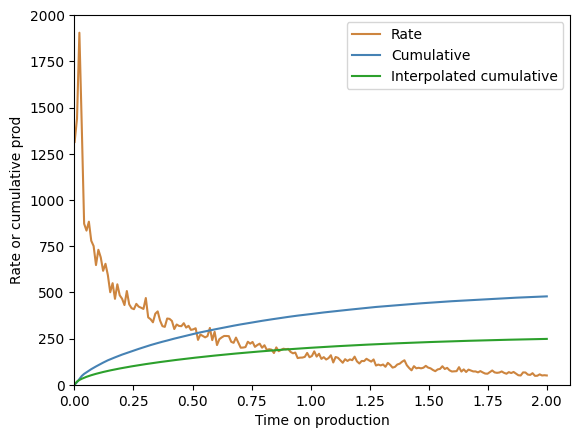

In [4]:
# Create test production to fit to
time_on_production = np.linspace(0.001, 2, 200)
tau_test = 2
M_test = 300
true_prod = M_test * derivative(rf_func, time_on_production / tau_test, dx=0.01)
production = true_prod * np.random.default_rng(42).normal(
    1, 0.1, size=len(time_on_production)
)
time_on_production = time_on_production  # [1:]
cum_production = cumtrapz(production, time_on_production, initial=0)

fig, ax = plt.subplots()
ax.plot(time_on_production, production, color="peru", label="Rate")
ax.plot(time_on_production, cum_production, color="steelblue", label="Cumulative")
ax.plot(
    time_on_production,
    M_test * rf_func2(time_on_production / tau_test),
    color="tab:green",
    label="Interpolated cumulative",
)
ax.set(
    xlabel="Time on production",
    ylabel="Rate or cumulative prod",
    xlim=(0, None),
    ylim=(0, None),
)
ax.legend()

## Introduce Bayesian inference

Here is the new part, where you specify the pymc model.


In [5]:
with pm.Model() as model:
    M = pm.LogNormal("M", mu=np.log(cum_production[-1]))
    tau = pm.LogNormal("tau", mu=1)
    sigma = pm.HalfCauchy("sigma", 20)
    Np = pm.Deterministic("Np", M * SplineWrapper(rf_func2)(time_on_production / tau))
    cum = pm.Normal("cum", Np, sigma, observed=cum_production)
    idata = pm.sample(return_inferencedata=True)
    posterior_predictive = pm.sample_posterior_predictive(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [cum]


Now we can plot the posterior estimates of M and tau:


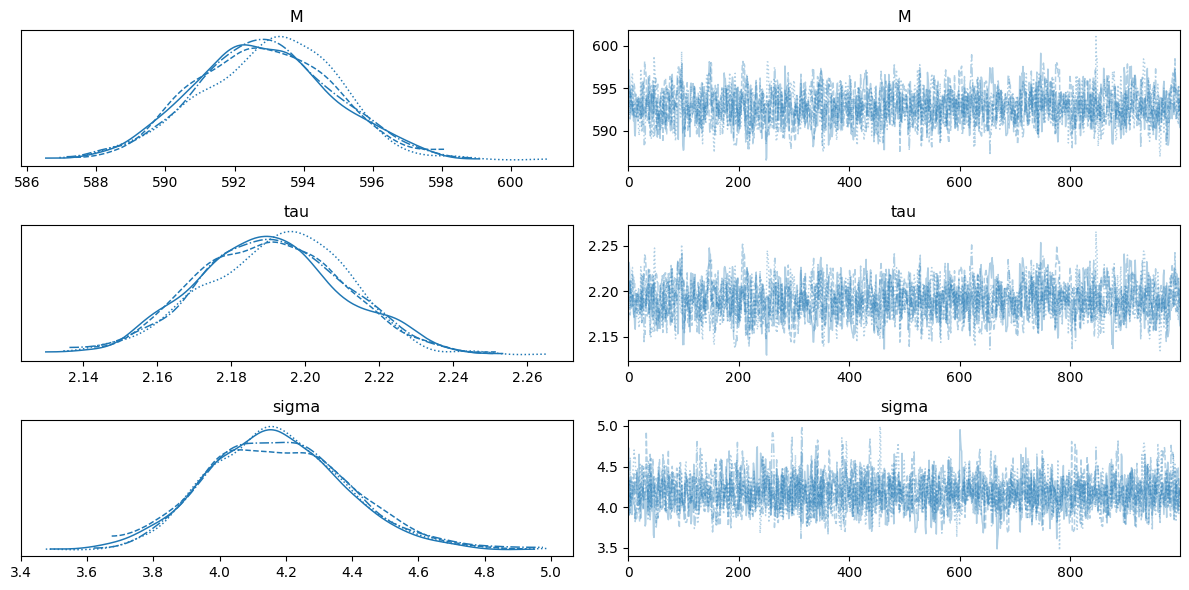

In [6]:
az.plot_trace(idata, ["M", "tau", "sigma"])
plt.tight_layout()

And compare to the data:


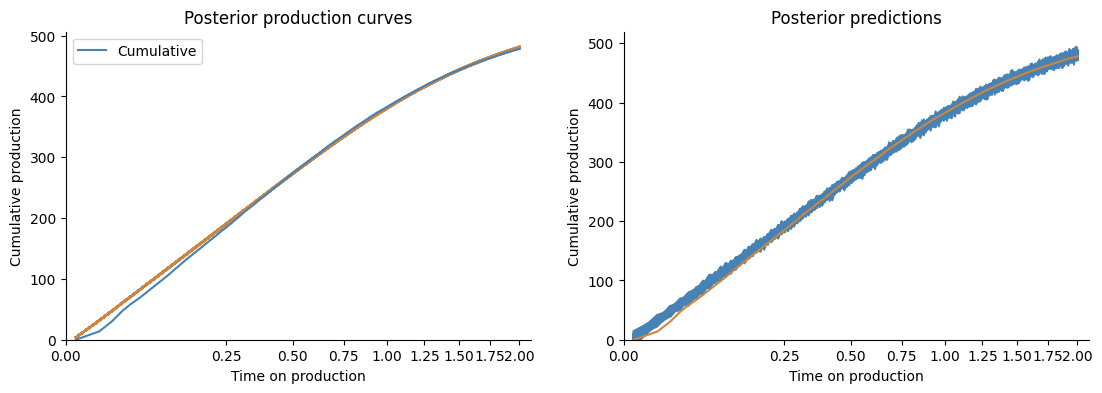

In [7]:
p = idata.posterior
rng = np.random.default_rng(405)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4 * 2 * 1.65, 4))
ax1.plot(
    time_on_production,
    az.extract(idata, num_samples=400)["Np"],
    alpha=0.1,
    color="peru",
)
ax1.plot(time_on_production, cum_production, color="steelblue", label="Cumulative")

ax1.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel="Time on production",
    ylabel="Cumulative production",
    xscale="squareroot",
    title="Posterior production curves",
)
ax1.legend()


ax2.plot(
    time_on_production,
    az.extract(posterior_predictive, group="posterior_predictive", num_samples=100)[
        "cum"
    ],
    color="steelblue",
)
ax2.plot(time_on_production, cum_production, color="peru")

ax2.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel="Time on production",
    ylabel="Cumulative production",
    xscale="squareroot",
    title="Posterior predictions",
)
sns.despine()